**Import packges

Eager execution- Define and Run is default for Keras, we want to set it to Define by Run(similar to Pytorch) to make research and development more intuitive.
Autotune- Make training batch process ASAP


In [37]:
import os, math, json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()
AUTO = tf.data.experimental.AUTOTUNE
import cv2
import random

import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model

Tensorflow version 1.13.1


Dataset from Kaggle:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/downloads/chest-xray-pneumonia.zip/2

In [2]:
# train, test, validation data
training_dir = r"D:\Document\Ben\python\Machine Learning\week 4\Assignment\train"
validation_dir = r"D:\Document\Ben\python\Machine Learning\week 4\Assignment\test"
test_dir = r"D:\Document\Ben\python\Machine Learning\week 4\Assignment\val"
categories = ['NORMAL','PNEUMONIA']
img_size = 299


Preprocessing and reading files

In [3]:
def get_data(file_path, categories, img_size):
    data = []
    for category in categories:
        c = categories.index(category)
        img_path = os.path.join(file_path, category)
        for img in os.listdir(img_path):
            try:
                a = cv2.imread(os.path.join(img_path, img))
                a = cv2.resize(a, (img_size, img_size))
                data.append([a, c])
            except Exception as e:
                pass
    return data

In [4]:
train = get_data(training_dir, categories, img_size)
test = get_data(test_dir, categories, img_size)
val = get_data(validation_dir, categories, img_size)

split each train, test and val datasets into x and y.

In [6]:
def spitdata_x_y(x, y, z):
    for i in z:
        x.append(i[0])
        y.append(i[1])

In [7]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

spitdata_x_y(x_train, y_train, train)
spitdata_x_y(x_test, y_test, test)
spitdata_x_y(x_val, y_val, val)

Display images from the train, test and val lists

NORMAL


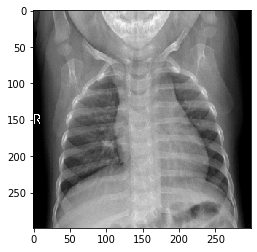

In [16]:
plt.imshow(x_train[1])
print(categories[y_train[1]])

NORMAL


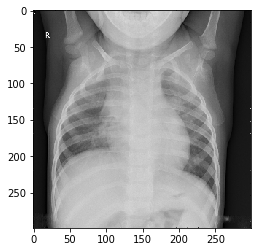

In [17]:
plt.imshow(x_test[1])
print(categories[y_test[1]])

NORMAL


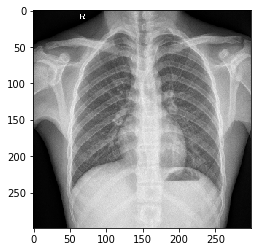

In [18]:
plt.imshow(x_val[1])
print(categories[y_val[1]])

Reshape X values

In [19]:
def reshapeX(x):
    x = np.array(x)
    x = x.reshape(-1, img_size, img_size, 3)
    return x

In [20]:
x_train = reshapeX(x_train)
x_test = reshapeX(x_test)
x_val = reshapeX(x_val)

In [24]:
import pickle
pkl = open('x_train', 'wb')
pickle.dump(x_train, pkl)
pkl.close()

In [25]:
pkl = open('y_train', 'wb')
pickle.dump(y_train, pkl)
pkl.close()

In [26]:
pkl = open('x_test', 'wb')
pickle.dump(x_test, pkl)
pkl.close()

In [27]:
pkl = open('y_test', 'wb')
pickle.dump(y_test, pkl)
pkl.close()

In [28]:
pkl = open('x_val', 'wb')
pickle.dump(x_val, pkl)
pkl.close()

In [29]:
pkl = open('y_val', 'wb')
pickle.dump(y_val, pkl)
pkl.close()

Machine Learning

In [32]:
layer_sizes = [32]
activation_layers = [1]
dense_layers = [1]

In [33]:
with open('x_train', 'rb+') as f:
    x_train = pickle.load(f)

with open('y_train', 'rb+') as f:
    y_train = pickle.load(f)

with open('x_test', 'rb+') as f:
    x_test = pickle.load(f)

with open('y_test', 'rb+') as f:
    y_test = pickle.load(f)
    
with open('x_val', 'rb+') as f:
    x_val = pickle.load(f)

with open('y_val', 'rb+') as f:
    y_val = pickle.load(f)

In [34]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [35]:
x_train = x_train/255
x_test = x_test/255
x_val = x_val/255

In [38]:
model = tf.keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
end = model.get_layer('avg_pool')
for i in range(model.layers.index(end)):
	model.layers[i].trainable = False

rmodel = Model(model.input, end.output)

In [41]:
import time
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Dropout, BatchNormalization, Dense, Flatten, Activation

In [ ]:
for layer_size in layer_sizes:
  for activation_layer in activation_layers:
    for dense_layer in dense_layers:

      NM = f"layer_size-{layer_size}, activation_layers-{activation_layer}, n_dense_layers-{dense_layer}-{time.time()}"
      tensorboard = TensorBoard(log_dir=f'logs/{NM}')

      model = Sequential()
      model.add(rmodel)

      model._layers[1].trainable = False

      for j in range(activation_layer):
        model.add(Activation('relu'))
    
      model.add(Flatten())

      for k in range(dense_layer):
        model.add(Dense(layer_size))
        model.add(Activation('relu'))
        model.add(Dropout(0.4))

      model.add(Dense(2))
      model.add(Activation("softmax"))

      opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)

      model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      file_path = "Health_app-{epoch:0.2f}-{val_loss:.3f}"
      model_checkpoint = ModelCheckpoint(f'models/{file_path}', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

      model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), callbacks=[tensorboard, model_checkpoint])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 5216 samples, validate on 16 samples
Epoch 1/100
1024/5216 [====>.........................] - ETA: 12:43:21 - loss: 0.4422 - acc: 0.7979

In [ ]:
model = tf.keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
end = model.get_layer('avg_pool')
for i in range(model.layers.index(end)):
	model.layers[i].trainable = False

rmodel = Model(model.input, end.output)

In [ ]:
model = Sequential()
model.add(rmodel)
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(layer_size))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(2))
model.add(Activation("softmax"))
model.load_weights("/content/Health_app-29.00-0.699")
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
scores = model.evaluate(x_val, y_val, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
n1 = random.randint(0,9)
plt.imshow(x_val[n1])
print(f'Predicted: {categories[np.argmax(model.predict(x_val)[n1])]}')
print(f'Real value: {categories[y_val[n1]]}')

In [ ]:
n2 = random.randint(0,9)
plt.imshow(x_val[n2])
print(f'Predicted: {categories[np.argmax(model.predict(x_val)[n2])]}')
print(f'Real value: {categories[y_val[n2]]}')

Preprocessing and reading files

In [31]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'


# Preprocessing
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='sigmoid')(x)
model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False
  
model.summary()
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

model.save('./Inception.H5')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


RuntimeError: tf.placeholder() is not compatible with eager execution.

In [ ]:
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)
        
        
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

In [ ]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [ ]:
# prints a integer for degugging
def debug(x):
    print("-"*40, x, "-"*40)

In [ ]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

In [ ]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

In [ ]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [ ]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [ ]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None

In [ ]:
reset_graph()
reset_callbacks()

In [ ]:

# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"


figure_directory = r"data/output/figures"

figure_directory = "data/output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

In [ ]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3

# Variables
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

# Preprocessing
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='sigmoid')(x)
model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

for layer in base_model.layers:
  layer.trainable = False
  
model.summary()
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

model.save('./Inception.H5')

# Prediction:
print('Input path: ')
img_path = input()
img = image.load_img(img_path,target_size=target_size)
test = image.img_to_array(img)
test = np.expand_dims(test, axis = 0)
res = model.predict(test)

print(res)
